## Trend Calculation [Argentina]


#### Importing the Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import display
import matplotlib.pyplot as plt
import warnings
import openpyxl
from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend
from datetime import datetime  # Import the datetime module
from sklearn.linear_model import LinearRegression

c:\Users\Andre Hee\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Cleaning the Data 

In [2]:
# Import the Data from the xlsx file
filename = r"pwt100.xlsx"  

# Load the "Data" sheet and filter for Argentina
df = pd.read_excel(filename, sheet_name="Data", engine="openpyxl")
filtered_df = df[df.iloc[:, 1] == "Argentina"].copy()  # Make an explicit copy

# Index Match the Header
legend_df = pd.read_excel(filename, sheet_name="Legend", engine="openpyxl") # Read the legend sheet
mapping = dict(zip(legend_df.iloc[:, 0].str.strip(), legend_df.iloc[:, 1].str.strip()))  # Clean mapping keys
filtered_df = filtered_df.rename(columns=lambda col: mapping[col] if col in mapping else col)

# Clean to numeric and datetime format
filtered_df.iloc[:, 4:] = filtered_df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')  # Ensure numeric data
filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], format='%Y', errors='coerce')
filtered_df.reset_index(drop=True).head(5)

,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,Share of merchandise exports at current PPPs,Share of merchandise imports at current PPPs,Share of residual trade and GDP statistical discrepancy at current PPPs,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1"
0,ARG,Argentina,Argentine Peso,1950-01-01,50303.953125,50108.761719,17.091824,6.608833,2034.000000,1.816503,...,0.122540,-0.060423,-0.012842,0.193067,0.422730,0.273050,0.117665,0.107814,0.292420,NaN
1,ARG,Argentina,Argentine Peso,1951-01-01,52677.964844,51339.167969,17.457578,6.713252,2037.866753,1.830769,...,0.100497,-0.074776,-0.016469,0.213862,0.366893,0.277869,0.142259,0.118755,0.264830,NaN
2,ARG,Argentina,Argentine Peso,1952-01-01,47677.207031,46855.101562,17.815967,6.819321,2041.740856,1.845147,...,0.077847,-0.058380,-0.033148,0.229605,0.366508,0.296447,0.126297,0.130694,0.268225,NaN
3,ARG,Argentina,Argentine Peso,1953-01-01,49529.671875,49917.148438,18.168618,6.927065,2045.622325,1.859638,...,0.106709,-0.041785,-0.022161,0.230860,0.370191,0.315614,0.110863,0.102362,0.267306,NaN
4,ARG,Argentina,Argentine Peso,1954-01-01,51835.375000,52254.769531,18.517168,7.036511,2049.511172,1.874243,...,0.108594,-0.051525,-0.029199,0.229684,0.381629,0.327768,0.094007,0.093510,0.273750,8.502229


## Trend calculation. Calculate a trend time paths for (the natural logs of) (i) realGDP and (ii) real GDP per capita at constant 2017 national prices using data over the whole sample. 

- As a robustness exercise, use the levels instead of log levels in the trend regression.
- There are 3 different ways of measuring GDP:
    - GDP by expenditure (Y = Government Expenditure + Investment + Net Exports + Consumption)
    - GDP by production (Y= Value Added + Taxes - Subsidies)
    - GDP by income (Y = labour Income + Rent + Profits)

### Rationale for Choosing Real GDP at constant 2017 national prices
1. Differences in GDP calculation
- Between **rgdpna (Real GDP at constant 2017 prices)**,**rconna (Real Consumption at constant 2017 prices)** and **rdana (Real domestic absorption at constant 2017 prices)** we decided on rgdpna because this reflects the overall real GDP of Argentina. Real consumption and real domestic absorption are subsets of real GDP and do not reflect the overall economic activity of the country.
2. Differences in Chained PPPs adjustment Vs national price indexing
- The **rdgpe** and **rdgpo** represent **expenditure side** and **output side real gdp at chained PPPs** - this measure adjusts GDP for differences in price levels across countries using Purchasing Power Parity (PPP) exchange rates, which are calculated based on the cost of a representative basket of goods in each country. The  large difference in real GDP at 2017 national prices with PPP adjusted real GDP can be attributed to Argentina's currency instability and inflation over the years

In [3]:
filtered_df[['Output-side real GDP at current PPPs (in mil. 2017US$)','Expenditure-side real GDP at current PPPs (in mil. 2017US$)','Real GDP at constant 2017 national prices (in mil. 2017US$)']].head(2)

,Output-side real GDP at current PPPs (in mil. 2017US$),Expenditure-side real GDP at current PPPs (in mil. 2017US$),Real GDP at constant 2017 national prices (in mil. 2017US$)
350,50511.765625,49204.300781,196688.453125
351,51700.113281,51548.027344,208305.203125


### Trend Time Paths

**Initial Investigation:** We fit the trend paths based on a 20 year rolling window. The reason for this is because we believe these time paths are sufficiently long to not capture short term fluctuations but sufficiently short to see long term structural shifts in the economy
 - Additive Linear Model
 $$ Y_t = \beta_0 + \beta_1(t+1) + \epsilon_t $$
 - Additive Quadratic Model
 $$ Y_t = \beta_0 + \beta_1(t+1) + \beta_2(t+1)^2 + \epsilon_t $$
 - Exponential Linear Model
 $$ \ln(Y_t) = \ln(\beta_0) + \beta_1 (t+1) + \ln(\epsilon_t) $$
 - Exponential Quadratic Model
 $$ \ln(Y_t) = \ln(\beta_0) + \beta_1 (t+1) + \beta_2 (t+1)^2 \ln(\epsilon_t) $$

**Subsequent Findings:** We then took a look at the data and realized that there was trend break in **1990** and **2011** for log real GDP. Given that 
$$ Y_t = Y_t^{business\:cycles} + Y_t^{long\:term} $$
we decided to plot  2 regressions to really ignore the noise from business fluctuations to capture the real long term real GDP of Argentina

### **(i) Real GDP - Subsequent Findings**

**Plotting Models with 2 fitted trend lines**

Based on the the ln(Real GDP) data, we decided to plot **3 trend lines** to capture the long term trend of the data. We believe that these reflect the structural shift in the Argentinian economy. The objective of this exercise is **not to** maximize the R-squared but to capture the long term trend of the data

1) **Trend Line 1 - 1950 to 1990**
2) **Trend Line 2 - 1991 to 2011**
3) **Trend Line 3 - 2012 to 2019**

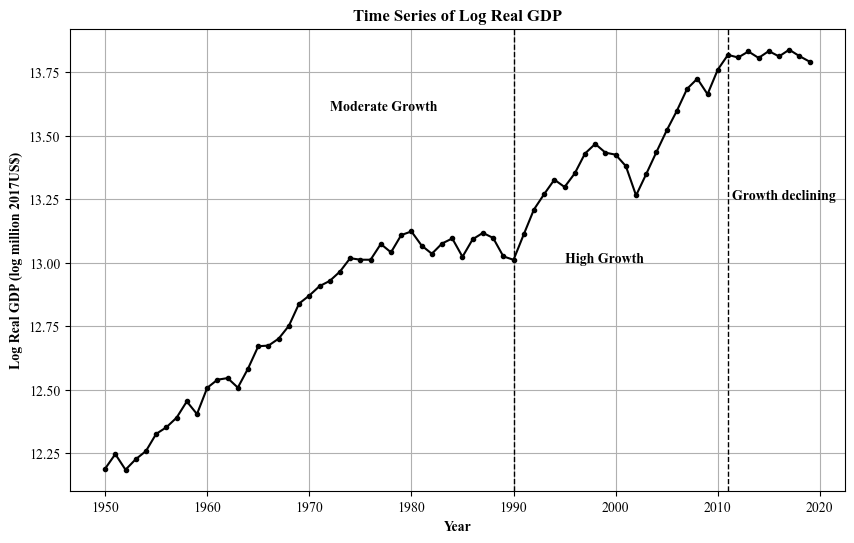

In [4]:

# Plot the time series graph for Log Real GDP per capita
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log(filtered_df['Real GDP at constant 2017 national prices (in mil. 2017US$)']), color='black', linestyle='-', marker='.')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Year',fontfamily='Times New Roman',fontweight='bold')
plt.ylabel('Log Real GDP (log million 2017US$)',fontfamily='Times New Roman',fontweight='bold')
plt.title('Time Series of Log Real GDP',fontfamily='Times New Roman',fontweight='bold')

# Add text annotations for periods (ensure values are log-transformed)
plt.text(pd.to_datetime('1972-01-01'), 13.6, "Moderate Growth", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')
plt.text(pd.to_datetime('1995-01-01'), 13, "High Growth", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')
plt.text(pd.to_datetime('2011-06-01'), 13.25, "Growth declining", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

##### Building the Models

In [5]:
beta_log_list = []
beta_1_list = []
beta_2_list = []
years = filtered_df['Year'].dt.year  # Extract years from the datetime format
ymin = years.min()  # Minimum year
ymax = years.max()  # Maximum year

# Define the three timeframes
timeframes = [
    (ymin, 1990),  # Period 1
    (1991, 2011),  # Period 2
    (2012, ymax)   # Period 3
]

Y = filtered_df['Real GDP at constant 2017 national prices (in mil. 2017US$)'].values

# Additive Linear Model
Yhat_add_linear_ = np.empty(len(years))  # Empty vector for estimated GDP trend

# Loop through each timeframe
for start_year, end_year in timeframes:
    # Mask for years in the current timeframe
    period_mask = (years >= start_year) & (years <= end_year)
    
    # Extract Y and define regressors for the timeframe
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_lin, b_add_lin = get_regression_coefs(Y_period, x1, x2)

        # Predict Yhat for this timeframe
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_linear_[t] = a_add_lin + b_add_lin * (idx + 1)  # Compute predictions


# Additive Quadratic Model
Yhat_add_quad_ = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year, end_year in timeframes:
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term
    x3 = x2 ** 2  # Quadratic term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y_period, x1, x2,x3)

        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_quad_[t] = a_add_quad + b_add_quad * (idx + 1) + c_add_quad * (idx + 1)**2  # Compute predictions


# Exponential Linear Model

Yhat_exp_linear_ = np.empty(len(years))  # Initialise an empty vector for estimated GDP trend

for start_year, end_year in timeframes:
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    t = np.arange(len(Y_period))  # Time variable
    
    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for multiplicative exponential growth
        log_Y_period = np.log(Y_period)  # Take log to linearize the model
        
        # Define regressors: Intercept term, (t+1), and (t+1)^2 for quadratic term
        X = np.column_stack((np.ones(len(t)), t + 1, (t + 1) ** 2))  
        
        # Get regression coefficients
        beta_log, beta_1, beta_2 = get_regression_coefs(log_Y_period, X[:, 0], X[:, 1], X[:, 2])  
        
        # Predict log(Yhat) and exponentiate to return to original scale
        for idx, year_idx in enumerate(np.where(period_mask)[0]):
            Yhat_exp_linear_[year_idx] = np.exp(beta_log + beta_1 * (t[idx] + 1) + beta_2 * (t[idx] + 1) ** 2)  # Convert back from log scale

# Exponential Quadratic Model
Yhat_exp_quad_ = np.empty(len(years))  # Initialise an empty vector for estimated GDP trend

for start_year, end_year in timeframes:
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y[period_mask]
    t = np.arange(len(Y_period))  # Time variable
    
    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for multiplicative exponential growth
        log_Y_period = np.log(Y_period)  # Take log to linearize the model
        
        # Define regressors: Intercept term, (t+1), and (t+1)^2 for quadratic term
        X = np.column_stack((np.ones(len(t)), t + 1, (t + 1) ** 2))  
        
        # Get regression coefficients
        beta_log, beta_1, beta_2 = get_regression_coefs(log_Y_period, X[:, 0], X[:, 1], X[:, 2])  
         # Store the coefficients
        beta_log_list.append(beta_log)
        beta_1_list.append(beta_1)
        beta_2_list.append(beta_2)
        # Predict log(Yhat) and exponentiate to return to original scale
        for idx, year_idx in enumerate(np.where(period_mask)[0]):
            Yhat_exp_quad_[year_idx] = np.exp(beta_log + beta_1 * (t[idx] + 1) + beta_2 * (t[idx] + 1) ** 2)  # Convert back from log scale

In [6]:
print("Coefficients for beta_2 for Exponential Quadratic Graphs:", beta_2_list)

Coefficients for beta_2 for Exponential Quadratic Graphs: [-0.0006311925904273208, 0.0008827734062455406, -0.0019045546887745957]


##### Plotting Subsequent Findings (Additive Models & Exponential Models)

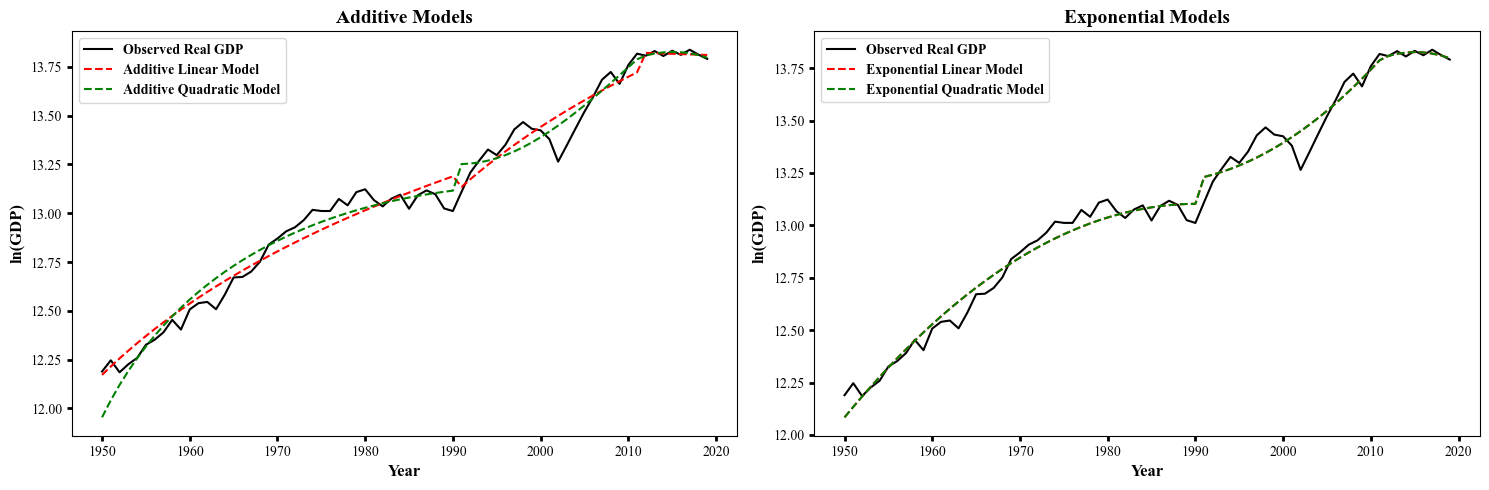

In [7]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Common style settings
font_settings = {'fontfamily': 'Times New Roman', 'fontweight': 'bold'}

# Plot Additive Models (left subplot)
ax1.plot(filtered_df["Year"], np.log(filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"]), 
         label="Observed Real GDP", color="black")  
ax1.plot(filtered_df["Year"], np.log(Yhat_add_linear_), 
         label="Additive Linear Model", linestyle="--", color="red")  
ax1.plot(filtered_df["Year"], np.log(Yhat_add_quad_), 
         label="Additive Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax1.set_xlabel("Year", **font_settings, fontsize=12)
ax1.set_ylabel("ln(GDP)", **font_settings, fontsize=12)
ax1.set_title("Additive Models", **font_settings, fontsize=14)
# Formatting the ticks
ax1.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add legend
ax1.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Plot Exponential Models (right subplot)
ax2.plot(filtered_df["Year"], np.log(filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"]), 
         label="Observed Real GDP", color="black")  
ax2.plot(filtered_df["Year"], np.log(Yhat_exp_linear_), 
         label="Exponential Linear Model", linestyle="--", color="red") 
ax2.plot(filtered_df["Year"], np.log(Yhat_exp_quad_), 
         label="Exponential Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax2.set_xlabel("Year", **font_settings, fontsize=12)
ax2.set_ylabel("ln(GDP)", **font_settings, fontsize=12)
ax2.set_title("Exponential Models", **font_settings, fontsize=14)
# Add legend
ax2.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Formatting the ticks
ax2.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Adjust layout
plt.tight_layout()
plt.show()


##### Plotting Models in Singular Graph

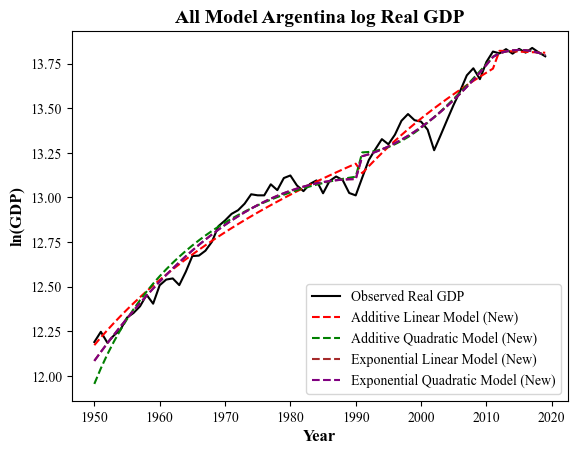

In [8]:
# Plot the results
plt.figure()
plt.plot(filtered_df["Year"], np.log(filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"]), label="Observed Real GDP",color="black")
plt.plot(filtered_df["Year"], np.log(Yhat_add_linear_), label="Additive Linear Model (New)", linestyle="--",color="red")
plt.plot(filtered_df["Year"], np.log(Yhat_add_quad_), label="Additive Quadratic Model (New)", linestyle="--",color="green")
plt.plot(filtered_df["Year"], np.log(Yhat_exp_linear_), label="Exponential Linear Model (New)", linestyle="--",color="brown")
plt.plot(filtered_df["Year"], np.log(Yhat_exp_quad_), label="Exponential Quadratic Model (New)", linestyle="--",color="purple")

# Add labels and title
plt.xlabel("Year", fontname='Times New Roman', fontsize=12, fontweight='bold')
plt.ylabel("ln(GDP)", fontname='Times New Roman', fontsize=12, fontweight='bold')
plt.title("All Model Argentina log Real GDP", fontname='Times New Roman', fontsize=14, fontweight='bold')

# Set font for ticks
plt.xticks(fontname='Times New Roman', fontsize=10)
plt.yticks(fontname='Times New Roman', fontsize=10)

# Add legend
plt.legend(fontsize=10, loc='lower right', prop={'family': 'Times New Roman'})

# Show the plot
plt.show()

### **(ii) Real GDP per Capita**

Learning from the previous exercise for real GDP, we proceed to segment the real GDP per capita into 3 trend lines to capture the long term trend of the data

1) **Trend Line 1 - 1950 to 1990**
2) **Trend Line 2 - 1991 to 2011**
3) **Trend Line 3 - 2012 to 2019**

In [9]:
# Creating Real GDP per capita
l = "Number of persons engaged (in millions)"
avh = "Average annual hours worked by persons engaged"
filtered_df['Year'] = pd.to_datetime(filtered_df['Year'], errors='coerce')
filtered_df['Labour_hours'] = filtered_df[l] * filtered_df[avh]
filtered_df['gdp_per_capita_column'] = filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"] / filtered_df['Labour_hours']


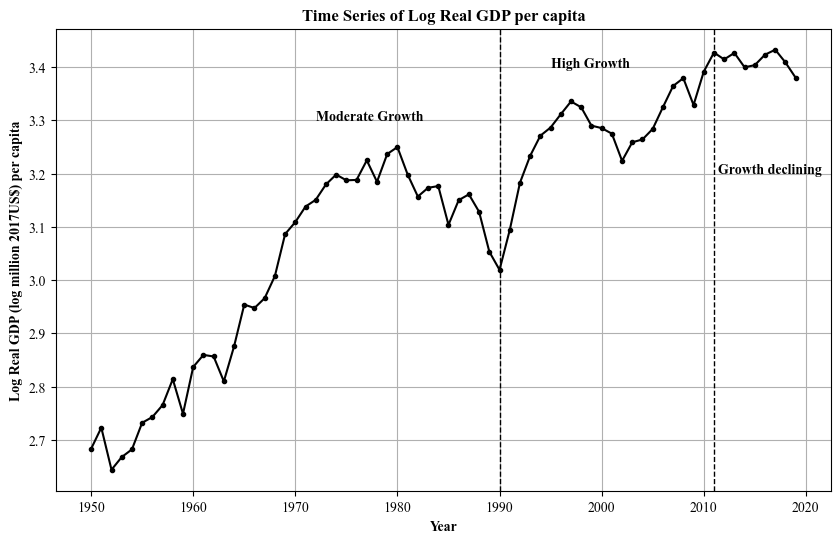

In [10]:
# Plot the time series graph for Log Real GDP per capita
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log(filtered_df['gdp_per_capita_column']), color='black', linestyle='-', marker='.')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Year',fontfamily='Times New Roman',fontweight='bold')
plt.ylabel('Log Real GDP (log million 2017US$) per capita',fontfamily='Times New Roman',fontweight='bold')
plt.title('Time Series of Log Real GDP per capita',fontfamily='Times New Roman',fontweight='bold')

# Add text annotations for periods (ensure values are log-transformed)
plt.text(pd.to_datetime('1972-01-01'), 3.3, "Moderate Growth", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')
plt.text(pd.to_datetime('1995-01-01'), 3.4, "High Growth", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')
plt.text(pd.to_datetime('2011-06-01'), 3.2, "Growth declining", color='black', fontsize=10, fontweight='bold',fontfamily='Times New Roman')


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

##### Recording Coefficients

In [11]:
Y_ = filtered_df['gdp_per_capita_column'].values
# Initialize list to store coefficient data
coefficients_data = []

# Helper function to record coefficients
def record_coefficients(model_name, start_year, end_year, coefficients):
    entry = {
        'Model': model_name,
        'Start_Year': start_year,
        'End_Year': end_year,
    }
    # Add coefficients with appropriate labels
    for i, coef in enumerate(coefficients):
        entry[f'Coef_{i+1}'] = coef
    coefficients_data.append(entry)

In [12]:
# Define the three timeframes
timeframes = [
    (ymin, 1990),  # Period 1
    (1991, 2011),  # Period 2
    (2012, ymax)   # Period 3
]

# Additive Linear Model
Yhat_add_linear_percapita = np.empty(len(years))  # Empty vector for estimated GDP trend

# Loop through each timeframe
for start_year, end_year in timeframes:
    # Mask for years in the current timeframe
    period_mask = (years >= start_year) & (years <= end_year)
    
    # Extract Y and define regressors for the timeframe
    Y_period = Y_[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_lin, b_add_lin = get_regression_coefs(Y_period, x1, x2)
        record_coefficients('Additive Linear', start_year, end_year, [a_add_lin, b_add_lin])
        # Predict Yhat for this timeframe
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_linear_percapita[t] = a_add_lin + b_add_lin * (idx + 1)  # Compute predictions


# Additive Quadratic Model
Yhat_add_quad_percapita = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend
for start_year, end_year in timeframes:
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    # Extract Y and define regressors for the period (may be less than 10 years for the last block)
    Y_period = Y_[period_mask]
    x1 = np.ones(len(Y_period))  # Intercept term
    x2 = np.arange(1, len(Y_period) + 1)  # Time trend term
    x3 = x2 ** 2  # Quadratic term

    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        a_add_quad, b_add_quad, c_add_quad = get_regression_coefs(Y_period, x1, x2,x3)
        record_coefficients('Additive Quadratic', start_year, end_year, [a_add_quad, b_add_quad, c_add_quad])
        # Predict Yhat for this period
        for idx, t in enumerate(np.where(period_mask)[0]):
            Yhat_add_quad_percapita[t] = a_add_quad + b_add_quad * (idx + 1) + c_add_quad * (idx + 1)**2  # Compute predictions


# Exponential Linear Model
Yhat_exp_linear_percapita = np.empty(len(years))  # Initialise an empty vector for the estimated GDP trend

for start_year, end_year in timeframes:
    period_mask = (years >= start_year) & (years <= end_year)  # Mask for years in the current block
    
    # Extract Y and define regressors for the period
    Y_period = Y_[period_mask]  # Use Y_ for per capita data
    t = np.arange(len(Y_period))  # Time variable
    
    # Perform regression only if there are years in the block
    if len(Y_period) > 0:
        # Transform Y for multiplicative exponential growth
        log_Y_period = np.log(Y_period)  # Take log to linearize the model

        # Define regressors: Intercept term and (t+1)
        X = np.column_stack((np.ones(len(t)), t + 1))  

        # Get regression coefficients
        beta_log, beta_1 = get_regression_coefs(log_Y_period, X[:, 0], X[:, 1])  

        # Record coefficients
        record_coefficients('Exponential Linear', start_year, end_year, [beta_log, beta_1])

        # Predict log(Yhat) and exponentiate to return to original scale
        for idx, year_idx in enumerate(np.where(period_mask)[0]):
            Yhat_exp_linear_percapita[year_idx] = np.exp(beta_log + beta_1 * (t[idx] + 1))  # Convert back from log scale
    
# Initialise an empty vector for the estimated GDP trend
Yhat_exp_quad_percapita = np.empty(len(years))  

for start_year, end_year in timeframes:  # <-- Unpack the tuple here
    period_mask = (years >= start_year) & (years <= end_year)
    Y_period = Y_[period_mask]  # Use Y_ for per capita data
    
    # Skip blocks with too few data points (e.g., <3 years)
    if len(Y_period) < 3:
        continue  
    
    # Time index for this block: 0-based index
    t = np.arange(len(Y_period))  # Now starts from 0
    
    # Transform Y for multiplicative exponential growth
    log_Y_period = np.log(Y_period)  # Take log to linearize the model
    
    # Define regressors: Intercept term, (t+1), and (t+1)^2 for quadratic term
    X = np.column_stack((np.ones(len(t)), t + 1, (t + 1) ** 2))  

    # Solve regression using your existing function
    beta_log, beta_1, beta_2 = get_regression_coefs(log_Y_period, X[:, 0], X[:, 1], X[:, 2])  

    # Record coefficients
    record_coefficients('Exponential Quadratic', start_year, end_year, [beta_log, beta_1, beta_2])

    # Predict log(Yhat) and exponentiate to return to original scale
    for idx, year_idx in enumerate(np.where(period_mask)[0]):
        Yhat_exp_quad_percapita[year_idx] = np.exp(beta_log + beta_1 * (t[idx] + 1) + beta_2 * (t[idx] + 1) ** 2)  # Convert back from log scale

In [13]:
df_coefficients = pd.DataFrame(coefficients_data)
df_coefficients

,Model,Start_Year,End_Year,Coef_1,Coef_2,Coef_3
0,Additive Linear,1950,1990,14.601382,0.273334,NaN
1,Additive Linear,1991,2011,24.398323,0.233770,NaN
2,Additive Linear,2012,2019,30.639179,-0.075097,NaN
3,Additive Quadratic,1950,1990,11.330895,0.729681,-0.010865
4,Additive Quadratic,1991,2011,24.493292,0.208995,0.001126
5,Additive Quadratic,2012,2019,30.010164,0.302312,-0.041934
6,Exponential Linear,1950,1990,2.695675,0.014227,NaN
7,Exponential Linear,1991,2011,3.195718,0.008768,NaN
8,Exponential Linear,2012,2019,3.422392,-0.002518,NaN
9,Exponential Quadratic,1950,1990,2.519091,0.038866,-0.000587


##### Plotting the findings for Real GDP per Capita

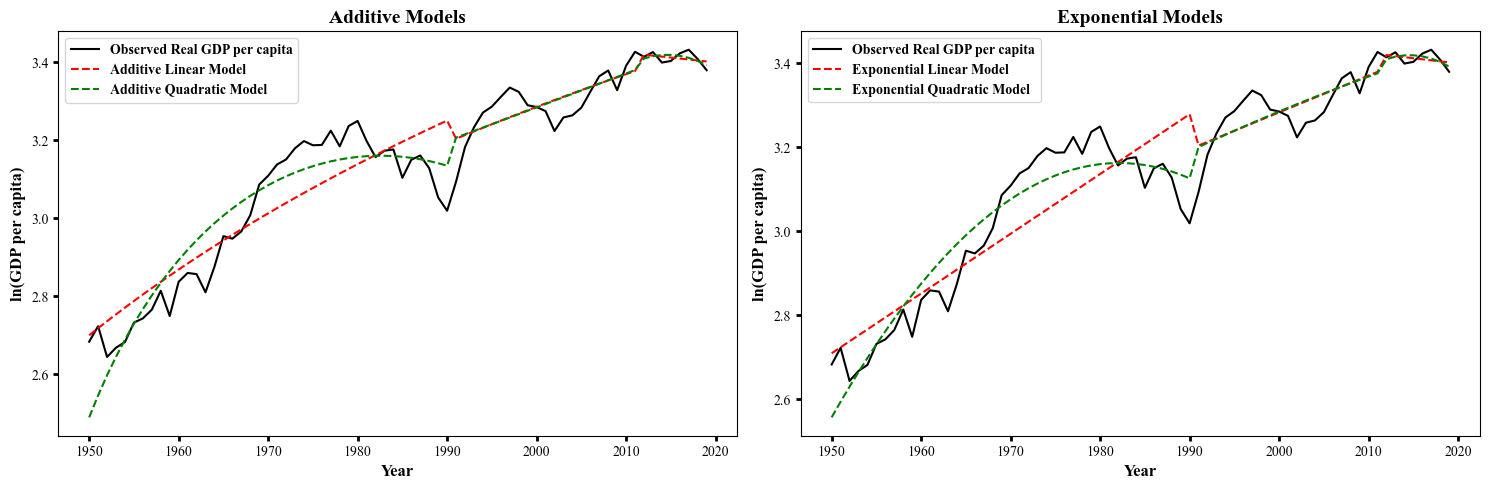

In [14]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Common style settings
font_settings = {'fontfamily': 'Times New Roman', 'fontweight': 'bold'}

# Plot Additive Models (left subplot)
ax1.plot(filtered_df["Year"], np.log(filtered_df['gdp_per_capita_column']), 
         label="Observed Real GDP per capita", color="black")  
ax1.plot(filtered_df["Year"], np.log(Yhat_add_linear_percapita), 
         label="Additive Linear Model", linestyle="--", color="red")  
ax1.plot(filtered_df["Year"], np.log(Yhat_add_quad_percapita), 
         label="Additive Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax1.set_xlabel("Year", **font_settings, fontsize=12)
ax1.set_ylabel("ln(GDP per capita)", **font_settings, fontsize=12)
ax1.set_title("Additive Models", **font_settings, fontsize=14)
# Formatting the ticks
ax1.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add legend
ax1.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Plot Exponential Models (right subplot)
ax2.plot(filtered_df["Year"],np.log(filtered_df['gdp_per_capita_column']), 
         label="Observed Real GDP per capita", color="black")
ax2.plot(filtered_df["Year"], np.log(Yhat_exp_linear_percapita), 
         label="Exponential Linear Model", linestyle="--", color="red")
ax2.plot(filtered_df["Year"], np.log(Yhat_exp_quad_percapita), 
         label="Exponential Quadratic Model", linestyle="--", color="green")

# Add labels and title with Times New Roman
ax2.set_xlabel("Year", **font_settings, fontsize=12)
ax2.set_ylabel("ln(GDP per capita)", **font_settings, fontsize=12)
ax2.set_title("Exponential Models", **font_settings, fontsize=14)
# Add legend
ax2.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Formatting the ticks
ax2.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Adjust layout
plt.tight_layout()
plt.show()


### Part B : Extracting TFP Measure

$$
Y = A K^\alpha (L)^{1-\alpha}, \quad 0 < \alpha < 1
$$


We will be using a Neutral Cobb-Douglas Production Function as expressed above.


$$
A = \frac{Y}{K^\alpha L^{1-\alpha}}, \quad 0 < \alpha < 1
$$



In [15]:
# Assume alpha = 0.3
alpha = 0.3


filtered_df.reset_index(drop=True).columns


h = "Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."
Y_label = "Real GDP at constant 2017 national prices (in mil. 2017US$)"
K = "Capital stock at constant 2017 national prices (in mil. 2017US$)"



# Use apply function to calculate A for each rows based on the values in the columns.
filtered_df["log A (Total Factor Productivity)"] = filtered_df.apply(
   lambda row: row[Y_label] / (row[K] ** alpha * (row[l] * row[avh]) ** (1 - alpha)),
   axis=1
).apply(np.log)
filtered_df



,3-letter ISO country code,Country name,Currency unit,Year,Expenditure-side real GDP at chained PPPs (in mil. 2017US$),Output-side real GDP at chained PPPs (in mil. 2017US$),Population (in millions),Number of persons engaged (in millions),Average annual hours worked by persons engaged,"Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.",...,"Price level of household consumption, price level of USA GDPo in 2017=1","Price level of capital formation, price level of USA GDPo in 2017=1","Price level of government consumption, price level of USA GDPo in 2017=1","Price level of exports, price level of USA GDPo in 2017=1","Price level of imports, price level of USA GDPo in 2017=1","Price level of the capital stock, price level of USA in 2017=1","Price level of the capital services, price level of USA=1",Labour_hours,gdp_per_capita_column,log A (Total Factor Productivity)
350,ARG,Argentina,Argentine Peso,1950-01-01,5.030395e+04,5.010876e+04,17.091824,6.608833,2034.000000,1.816503,...,0.193067,0.422730,0.273050,0.117665,0.107814,0.292420,NaN,13442.365989,14.631982,1.696400
351,ARG,Argentina,Argentine Peso,1951-01-01,5.267796e+04,5.133917e+04,17.457578,6.713252,2037.866753,1.830769,...,0.213862,0.366893,0.277869,0.142259,0.118755,0.264830,NaN,13680.713190,15.226195,1.713435
352,ARG,Argentina,Argentine Peso,1952-01-01,4.767721e+04,4.685510e+04,17.815967,6.819321,2041.740856,1.845147,...,0.229605,0.366508,0.296447,0.126297,0.130694,0.268225,NaN,13923.285641,14.069829,1.620501
353,ARG,Argentina,Argentine Peso,1953-01-01,4.952967e+04,4.991715e+04,18.168618,6.927065,2045.622325,1.859638,...,0.230860,0.370191,0.315614,0.110863,0.102362,0.267306,NaN,14170.158594,14.408087,1.630207
354,ARG,Argentina,Argentine Peso,1954-01-01,5.183538e+04,5.225477e+04,18.517168,7.036511,2049.511172,1.874243,...,0.229684,0.381629,0.327768,0.094007,0.093510,0.273750,8.502229,14421.408769,14.618028,1.633497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,ARG,Argentina,Argentine Peso,2015-01-01,9.148502e+05,9.131035e+05,43.075416,19.854450,1703.468539,2.975289,...,0.814612,0.825699,0.446212,0.633933,0.620426,0.541800,1.215443,33821.431323,30.072493,2.039279
416,ARG,Argentina,Argentine Peso,2016-01-01,9.113680e+05,9.087713e+05,43.508460,19.723175,1646.512532,3.005213,...,0.704616,0.736538,0.377989,0.627567,0.613758,0.467809,1.056981,32474.454895,30.668284,2.041762
417,ARG,Argentina,Argentine Peso,2017-01-01,1.026128e+06,1.022513e+06,43.937140,20.033661,1648.812832,3.035439,...,0.640839,0.770372,0.498410,0.637246,0.614945,0.512517,1.143677,33031.757143,30.955460,2.049778
418,ARG,Argentina,Argentine Peso,2018-01-01,1.025861e+06,1.021129e+06,44.361150,20.135071,1638.440039,3.065968,...,0.521541,0.660731,0.376825,0.664090,0.630823,0.412905,0.875886,32990.106191,30.225323,2.020492


#### Plotting a time series for A

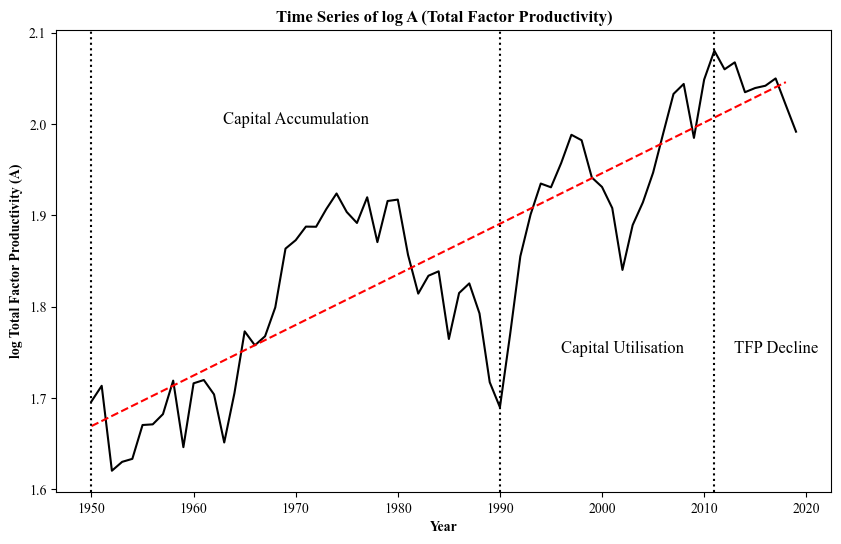

In [16]:
# Set font to Times New Roman
plt.rc('font', family='Times New Roman')

# Convert datetime to numerical years for regression
years_tfp = np.array(filtered_df['Year'].dt.year).reshape(-1, 1)
tfp_values = np.array(filtered_df["log A (Total Factor Productivity)"])

# indices
idx_tfp = (filtered_df['Year'] >= datetime(1950, 1, 1)) & (filtered_df['Year'] < datetime(2019, 1, 1))

# Fit linear regression for 1950-1990
model_tfp = LinearRegression().fit(years_tfp[idx_tfp], tfp_values[idx_tfp])
trend_tfp = model_tfp.predict(years_tfp[idx_tfp])

# Create figure
plt.figure(figsize=(10, 6))

# Plot original TFP data
plt.plot(filtered_df['Year'], filtered_df["log A (Total Factor Productivity)"], color='black', linestyle='-')

# Plot trend lines
plt.plot(filtered_df['Year'][idx_tfp], trend_tfp, color='red', linestyle='dashed', label="Trend 1950-2019")

# Add vertical dotted lines
plt.axvline(x=datetime(1950, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(1990, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(2011, 1, 1), color='black', linestyle='dotted')

## Add annotations for the periods
plt.annotate('Capital Accumulation', xy=(datetime(1970, 1, 1), 2.00), ha='center', color='black', fontsize=12)
plt.annotate('Capital Utilisation', xy=(datetime(2002, 1, 1), 1.75), ha='center', color='black', fontsize=12)
plt.annotate('TFP Decline', xy=(datetime(2017, 1, 1), 1.75), ha='center', color='black', fontsize=12)

# Labels and title
plt.xlabel('Year', fontweight="bold")
plt.ylabel("log Total Factor Productivity (A)", fontweight="bold")
plt.title("Time Series of log A (Total Factor Productivity)", fontweight="bold")

# Show plot
plt.show()


### Part C : Growth Accounting

In [17]:
def compute_growth_rate(X):
   #np.log is the natural logarithm by default in numpy
   #use of index slicing, e.g. X[1:] are all values starting from the second element, X[:-1] all elements up until (but not including) the last element
   return np.log(X[1:] / X[:-1])


dY = compute_growth_rate(filtered_df[Y_label].values)
dA = filtered_df['log A (Total Factor Productivity)'].values[1:] - filtered_df['log A (Total Factor Productivity)'].values[:-1]
dK = compute_growth_rate(filtered_df[K].values)
dL = compute_growth_rate((filtered_df[l] * filtered_df[avh]).values)



$$
\begin{aligned}
\text{contr\_K} &= \alpha \cdot \frac{g_K}{g_Y} \\
\text{contr\_L} &= (1 - \alpha) \cdot \frac{g_L}{g_Y} \\
\text{contr\_A} &= \frac{g_A}{g_Y}
\end{aligned}
$$


In [42]:
def compute_growth_rates(start_year, end_year, df, Y_label, K, l, avh, A_label):

    # Compute log differences for Y and K
    YK_growth = np.log(
        df.loc[df['Year'].dt.year == end_year, [Y_label, K]].iloc[0].values /
        df.loc[df['Year'].dt.year == start_year, [Y_label, K]].iloc[0].values
    ).tolist()

    # Compute log difference for labor input (L * avh)
    L_growth = np.log(
        (df.loc[df['Year'].dt.year == end_year, l].iloc[0] *
         df.loc[df['Year'].dt.year == end_year, avh].iloc[0]) /
        (df.loc[df['Year'].dt.year == start_year, l].iloc[0] *
         df.loc[df['Year'].dt.year == start_year, avh].iloc[0])
    )

    # Compute log difference for total factor productivity (TFP)
    A_growth = df.loc[df['Year'].dt.year == end_year, A_label].iloc[0] - \
               df.loc[df['Year'].dt.year == start_year, A_label].iloc[0]

    return YK_growth + [L_growth, A_growth]

def compute_contributions(avg_growth_rates, alpha):
    df_contribs = avg_growth_rates.copy()
    
    df_contribs['K contribution'] = alpha * (df_contribs['K growth'] / df_contribs['Y growth'])
    df_contribs['L contribution'] = (1 - alpha) * (df_contribs['L growth'] / df_contribs['Y growth'])
    df_contribs['A contribution'] = df_contribs['A growth'] / df_contribs['Y growth']
    
    return df_contribs[['Y growth', 'K contribution', 'L contribution', 'A contribution']]

# Define time periods for analysis
time_periods = [("1950-1990", 1950, 1990), ("1991-2011", 1990, 2011), ("2012-2019", 2011, 2019)]

# Compute growth rates for each period and store in DataFrame
avg_growth_rates = pd.DataFrame(
    {year: compute_growth_rates(start, end, filtered_df, Y_label, K, l, avh, 'log A (Total Factor Productivity)') 
     for year, start, end in time_periods}
).T

# Rename columns for clarity
avg_growth_rates.columns = ['Y growth', 'K growth', 'L growth', 'A growth']

# Compute contributions
df_contribs_long = compute_contributions(avg_growth_rates, alpha)

# Display the results
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_contribs_long)


           Y growth  K contribution  L contribution  A contribution
1950-1990    0.8219          0.5940          0.4138         -0.0078
1991-2011    0.8063          0.1703          0.3458          0.4839
2012-2019   -0.0267         -1.7771         -0.5361          3.3132


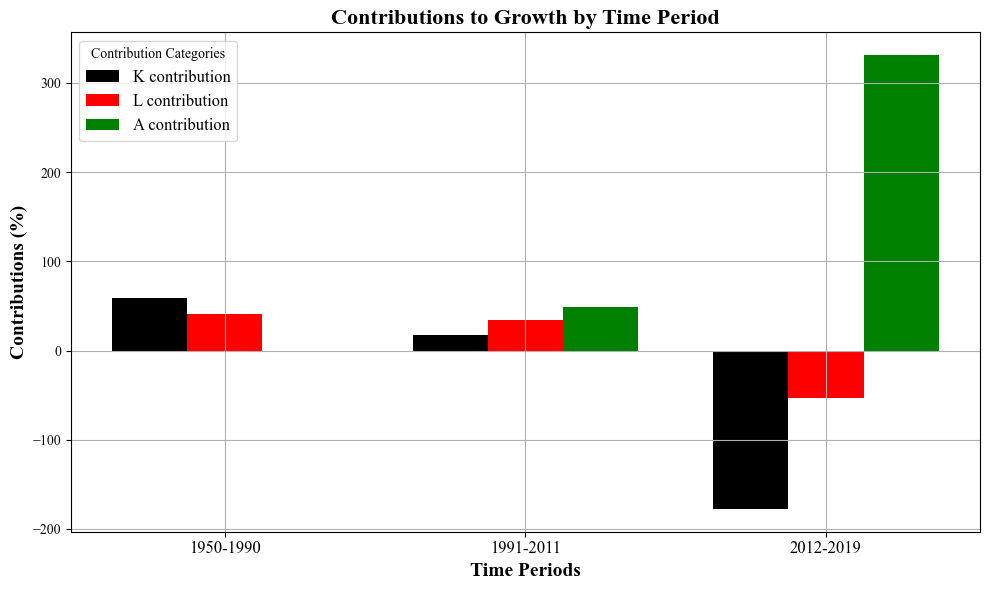

In [43]:
# Reset the index for plotting
df_contribs_long_plot = df_contribs_long.reset_index()
df_contribs_long_plot.rename(columns={'index': 'year'}, inplace=True)


# Extract data for plotting
time_periods = df_contribs_long_plot['year']
#time_periods = ["1950-1990", "1991-2011", "2012-2019"]  
categories = ['K contribution', 'L contribution', 'A contribution']
values = df_contribs_long_plot[categories].values * 100  # Convert contributions to percentages


# Create a bar plot
x = range(len(time_periods))  # Position of groups
width = 0.25  # Width of each bar
offsets = [-width, 0, width]  # Offsets for grouped bars


plt.figure(figsize=(10, 6))


# Define colors for each category
colors = ['black', 'red', 'green']


# Plot each contribution category with specified colors
for i, category in enumerate(categories):
   plt.bar(
       [pos + offsets[i] for pos in x],  # Adjust positions for grouping
       values[:, i],  # Contribution values for the category (now in percentages)
       width,
       label=category,
       color=colors[i]  # Set the color for each category
   )

# Formatting the plot with Times New Roman font
plt.xlabel('Time Periods', fontname='Times New Roman', fontsize=14, fontweight ="bold")
plt.ylabel('Contributions (%)', fontname='Times New Roman', fontsize=14, fontweight ="bold")  # Update y-axis label to reflect percentage scale
plt.title('Contributions to Growth by Time Period', fontname='Times New Roman', fontsize=16, fontweight ="bold")
plt.xticks(x, time_periods, fontname='Times New Roman', fontsize=12)
plt.legend(title='Contribution Categories', prop={'family': 'Times New Roman', 'size': 12})
plt.tight_layout()
plt.grid(True)


# Show the plot
plt.show()


$$
Y = A'h K^\alpha (L)^{1-\alpha}, \quad 0 < \alpha < 1, \quad A = A'h
$$

$$
A' = \frac{Y}{h K^\alpha L^{1-\alpha}}, \quad 0 < \alpha < 1
$$

In [20]:
# Use apply function to calculate A' for each row based on the values in the columns. We define labour as the product of the number of persons engaged and average annual hours worked.
filtered_df["log A' (Total Factor Productivity)"] = filtered_df.apply(
   lambda row: row[Y_label] / (row[h] * row[K] ** alpha * (row[l] * row[avh]) ** (1 - alpha)),
   axis=1
).apply(np.log)  # Take the natural logarithm of the TFP values

#### Plotting a time-series for A'

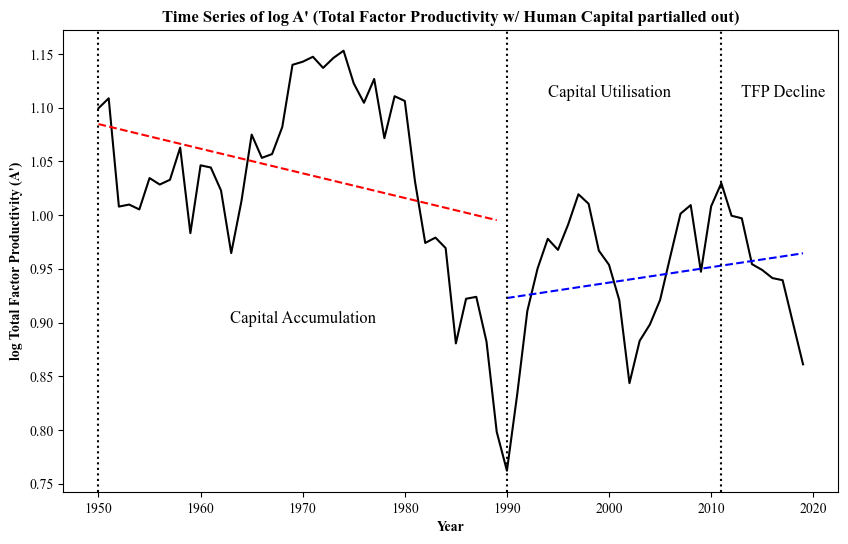

In [21]:
# Convert datetime to numerical years for regression
years_tfp_no_hc = np.array(filtered_df['Year'].dt.year).reshape(-1, 1)
tfp_no_hc_values = np.array(filtered_df["log A' (Total Factor Productivity)"])

# Split indices for 1950-1990 and 1990-2019
idx_tfp_no_hc_1950_1990 = (filtered_df['Year'] >= datetime(1950, 1, 1)) & (filtered_df['Year'] < datetime(1990, 1, 1))
idx_tfp_no_hc_1990_2019 = (filtered_df['Year'] >= datetime(1990, 1, 1)) & (filtered_df['Year'] <= datetime(2019, 1, 1))

# Fit linear regression for 1950-1990
model_tfp_no_hc_1950_1990 = LinearRegression().fit(years_tfp_no_hc[idx_tfp_no_hc_1950_1990], tfp_no_hc_values[idx_tfp_no_hc_1950_1990])
trend_tfp_no_hc_1950_1990 = model_tfp_no_hc_1950_1990.predict(years_tfp_no_hc[idx_tfp_no_hc_1950_1990])

# Fit linear regression for 1990-2019
model_tfp_no_hc_1990_2019 = LinearRegression().fit(years_tfp_no_hc[idx_tfp_no_hc_1990_2019], tfp_no_hc_values[idx_tfp_no_hc_1990_2019])
trend_tfp_no_hc_1990_2019 = model_tfp_no_hc_1990_2019.predict(years_tfp_no_hc[idx_tfp_no_hc_1990_2019])

# Create figure
plt.figure(figsize=(10, 6))

# Plot original TFP data
plt.plot(filtered_df['Year'], filtered_df["log A' (Total Factor Productivity)"], color='black', linestyle='-')

# Plot trend lines
plt.plot(filtered_df['Year'][idx_tfp_no_hc_1950_1990], trend_tfp_no_hc_1950_1990, color='red', linestyle='dashed', label="Trend 1950-1990")
plt.plot(filtered_df['Year'][idx_tfp_no_hc_1990_2019], trend_tfp_no_hc_1990_2019, color='blue', linestyle='dashed', label="Trend 1990-2019")

# Add vertical dotted lines
plt.axvline(x=datetime(1950, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(1990, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(2011, 1, 1), color='black', linestyle='dotted')

# Add annotations for the periods
plt.annotate('Capital Accumulation', xy=(datetime(1970, 1, 1), 0.90), ha='center', color='black', fontsize=12)
plt.annotate('Capital Utilisation', xy=(datetime(2000, 1, 1), 1.11), ha='center', color='black', fontsize=12)
plt.annotate('TFP Decline', xy=(datetime(2017, 1, 1), 1.11), ha='center', color='black', fontsize=12)

# Labels and title
plt.xlabel('Year', fontweight="bold")
plt.ylabel("log Total Factor Productivity (A')", fontweight="bold")
plt.title("Time Series of log A' (Total Factor Productivity w/ Human Capital partialled out)", fontweight="bold")

# Show plot
plt.show()


#### Expressing A' and h in terms of contribution to Long-Term Growth Rates

In [38]:
# Decomposing the contribution of A as a product of A' and Ht where Ht is the human capital index
h = "Human capital index, based on years of schooling and returns to education; see Human capital in PWT9."


# Calculate human capital (h) growth rates
h_growth = [
   np.log(
       filtered_df.loc[filtered_df['Year'].dt.year == 1990, h].iloc[0] /
       filtered_df.loc[filtered_df['Year'].dt.year == 1950, h].iloc[0]
   ),
   np.log(
       filtered_df.loc[filtered_df['Year'].dt.year == 2011, h].iloc[0] /
       filtered_df.loc[filtered_df['Year'].dt.year == 1991, h].iloc[0]
   ),
   np.log(
       filtered_df.loc[filtered_df['Year'].dt.year == 2019, h].iloc[0] /
       filtered_df.loc[filtered_df['Year'].dt.year == 2012, h].iloc[0]
   )
]


# Calculate h contribution
h_contribution = (1 - alpha) * (np.array(h_growth) / avg_growth_rates['Y growth'].values)


# Calculate A' contribution as residual of A (A' = A - h)
A_star_contribution = df_contribs_long['A contribution'] - h_contribution


# Create a new DataFrame with the percentage contributions
df_contribs_percentage = pd.DataFrame({
   "h contribution": h_contribution,
   "A' contribution": A_star_contribution,
   "Y growth": avg_growth_rates['Y growth'].values
}, index=avg_growth_rates.index)


# Display the extended DataFrame
pd.set_option('display.float_format', '{:.4f}'.format)
print(df_contribs_percentage)


           h contribution  A' contribution  Y growth
1950-1990          0.2818          -0.2897    0.8219
1990-2011          0.0983           0.3856    0.8063
2011-2019         -1.8341           5.1473   -0.0267


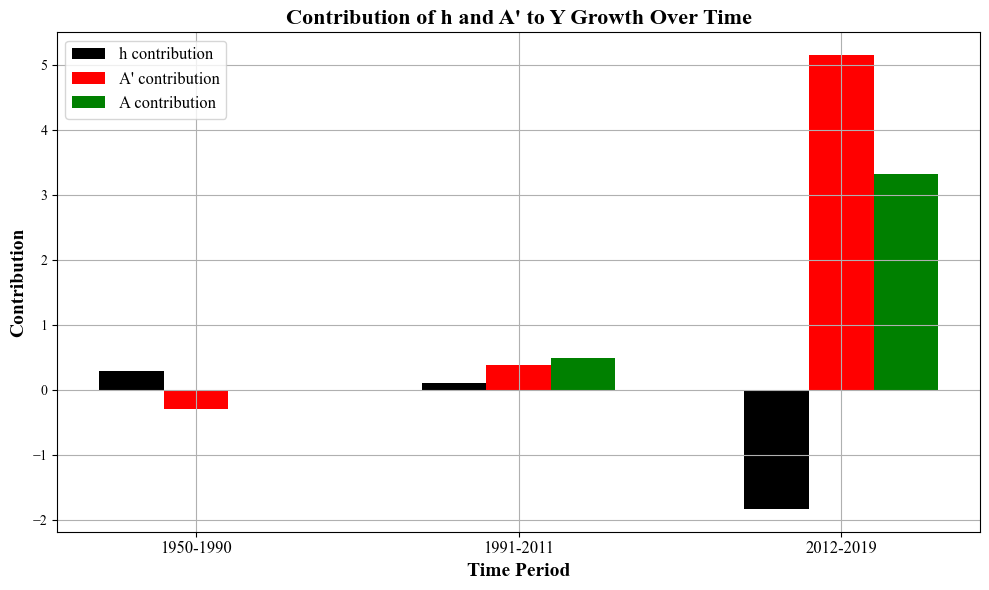

In [41]:
time_periods = ["1950-1990", "1991-2011", "2012-2019"]  # Time periods

# Define positions for the bars
x = np.arange(len(time_periods))  # Time period indices
width = 0.2  # Width of bars to ensure spacing


# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))


# Plot bars for each category, shifting positions to avoid overlap
bars1 = ax.bar(x - width, h_contribution, width, label="h contribution", color="black")
bars2 = ax.bar(x, A_star_contribution, width, label="A' contribution", color="red")
bars3 = ax.bar(x + width, df_contribs_long['A contribution'], width, label="A contribution", color="green")


# Add labels, title, and legend
ax.set_xlabel("Time Period", fontsize=14, fontweight="bold")
ax.set_ylabel("Contribution", fontsize=14, fontweight="bold")
ax.set_title("Contribution of h and A' to Y Growth Over Time", fontsize=16, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(time_periods, fontsize=12)
ax.legend(fontsize=12)


# Apply grid and layout adjustments
plt.tight_layout()
plt.grid(True)


# Show the plot
plt.show()

#### Plotting time-series of gross capital formation

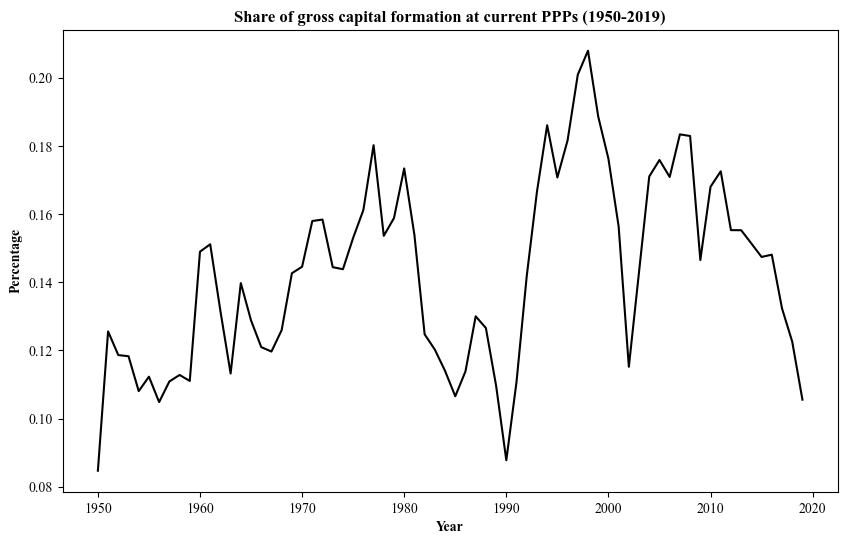

In [24]:
# Plot a time series graph of labour productivity and total factor productivity, normalise y-values using log
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['Share of gross capital formation at current PPPs'], color='black', linestyle='-')

plt.xlabel('Year',fontweight="bold")
plt.ylabel('Percentage',fontweight="bold")
plt.title('Share of gross capital formation at current PPPs (1950-2019)',fontweight="bold")
plt.show()


### Part D : Extracting Labour Productivity

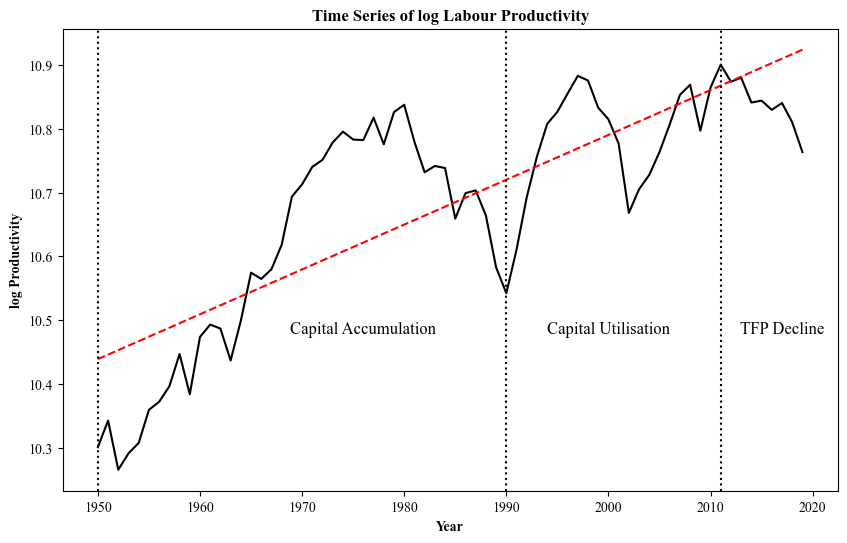

In [25]:
filtered_df['log Labour Productivity'] = np.log(filtered_df['Real GDP at constant 2017 national prices (in mil. 2017US$)'] / (filtered_df['Number of persons engaged (in millions)']))

# Convert datetime to numerical years for regression
years_labour_prod = np.array(filtered_df['Year'].dt.year).reshape(-1, 1)
labour_prod_values = np.array(filtered_df["log Labour Productivity"])

# Fit linear regression for Labour Productivity over the whole period
model_labour_prod = LinearRegression().fit(years_labour_prod, labour_prod_values)
trend_labour_prod = model_labour_prod.predict(years_labour_prod)

# Create figure
plt.figure(figsize=(10, 6))

# Plot original Labour Productivity data
plt.plot(filtered_df['Year'], labour_prod_values, color='black', linestyle='-', label='Labour Productivity')

# Plot single trend line for Labour Productivity
plt.plot(filtered_df['Year'], trend_labour_prod, color='red', linestyle='dashed', label="Labour Productivity Trend")

# Add vertical dotted lines
plt.axvline(x=datetime(1950, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(1990, 1, 1), color='black', linestyle='dotted')
plt.axvline(x=datetime(2011, 1, 1), color='black', linestyle='dotted')

# Add annotations for the periods
plt.annotate('Capital Accumulation', xy=(datetime(1976, 1, 1), 10.48), ha='center', color='black', fontsize=12)
plt.annotate('Capital Utilisation', xy=(datetime(2000, 1, 1), 10.48), ha='center', color='black', fontsize=12)
plt.annotate('TFP Decline', xy=(datetime(2017, 1, 1), 10.48), ha='center', color='black', fontsize=12)

# Labels and title
plt.xlabel('Year', fontweight="bold")
plt.ylabel('log Productivity', fontweight="bold")
plt.title('Time Series of log Labour Productivity', fontweight="bold")

# Show plot
plt.show()


### Solow Model (Supplementary Data) 
- Log K against t
- Log L against t
- Log A against t
- Log K/L (k) against t
- Log K/AL (k tilde) against t

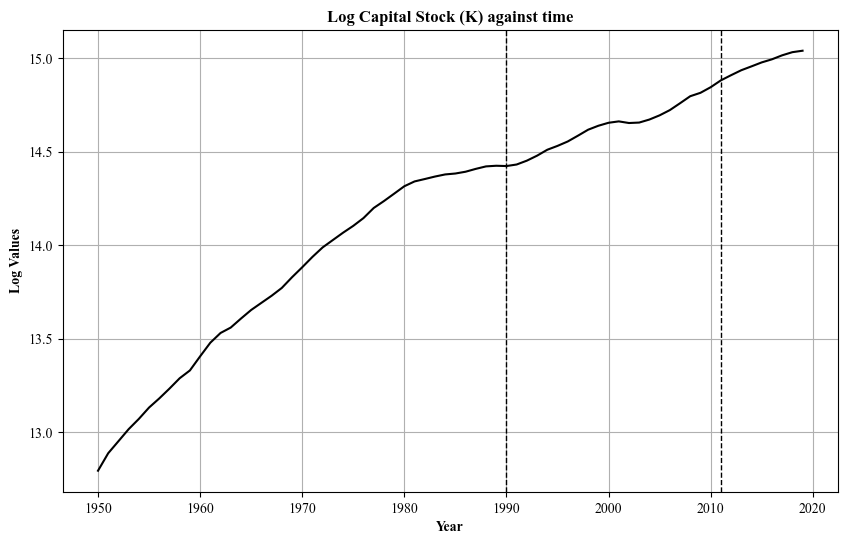

In [26]:
# Plotting K against time 
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log (filtered_df['Capital stock at constant 2017 national prices (in mil. 2017US$)']), color='black', linestyle='-')
# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log Capital Stock (K) against time', 
          fontfamily='Times New Roman', fontweight='bold')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()



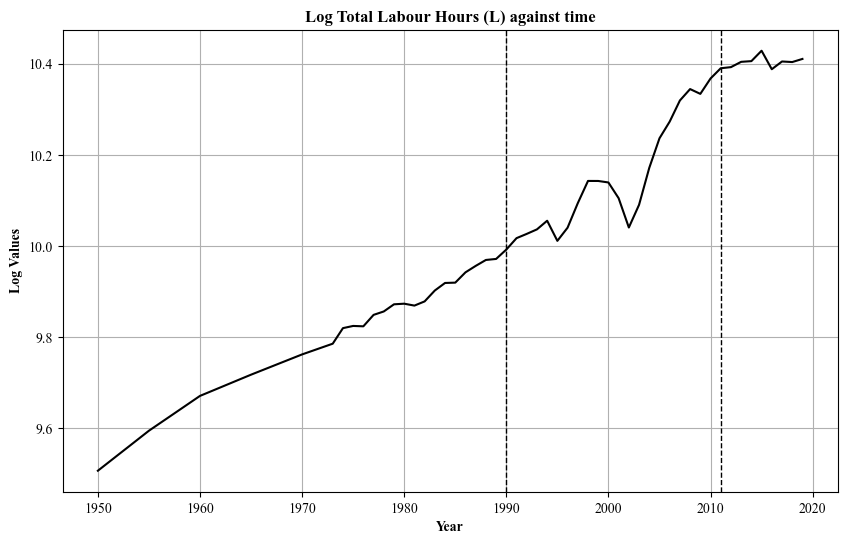

In [27]:
# Plotting L against time 
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log (filtered_df[l]*filtered_df[avh]), color='black', linestyle='-')
# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log Total Labour Hours (L) against time', 
          fontfamily='Times New Roman', fontweight='bold')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()


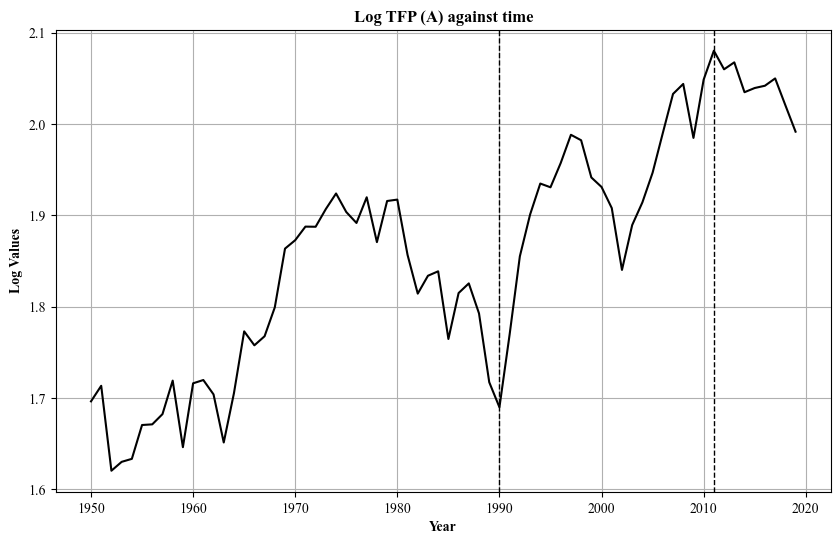

In [28]:
# Plotting A against time 
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], filtered_df['log A (Total Factor Productivity)'], color='black', linestyle='-')
# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log TFP (A) against time', 
          fontfamily='Times New Roman', fontweight='bold')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

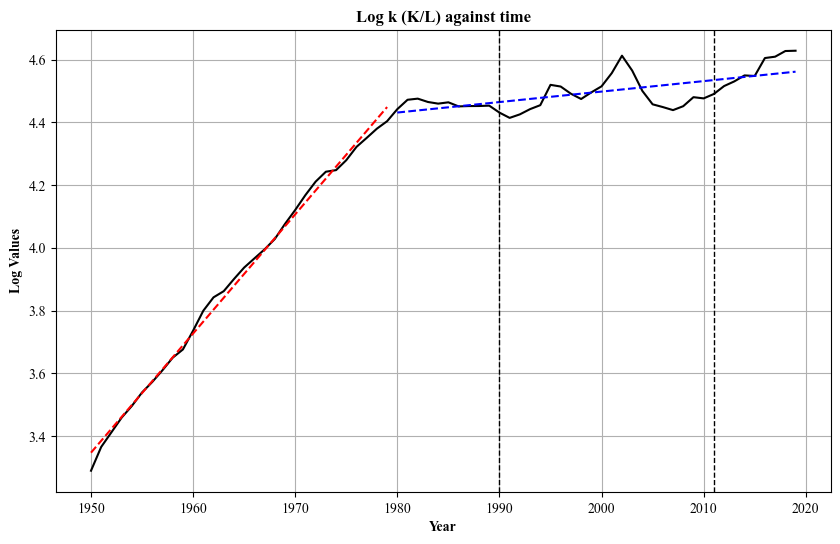

In [29]:
# Plotting K/L (k) against time
filtered_df["k (K/L)"] = filtered_df['Capital stock at constant 2017 national prices (in mil. 2017US$)'] / (filtered_df[l]*filtered_df[avh])

# Convert datetime to numerical years for regression
years_k_no_hc = np.array(filtered_df['Year'].dt.year).reshape(-1, 1)
k_values = np.array(filtered_df["k (K/L)"])

# Split the indices into 1950-1990 and 1990-2019
idx_k_1950_1980 = (filtered_df['Year'] >= datetime(1950, 1, 1)) & (filtered_df['Year'] < datetime(1980, 1, 1))
idx_k_1980_2019 = (filtered_df['Year'] >= datetime(1980, 1, 1)) & (filtered_df['Year'] <= datetime(2019, 1, 1))

# Fit linear regression for 1950-1990
model_k_1950_1980 = LinearRegression().fit(years_k_no_hc[idx_k_1950_1980], np.log(k_values[idx_k_1950_1980]))
trend_k_1950_1980 = model_k_1950_1980.predict(years_k_no_hc[idx_k_1950_1980])

# Fit linear regression for 1990-2019
model_k_1980_2019 = LinearRegression().fit(years_k_no_hc[idx_k_1980_2019], np.log(k_values[idx_k_1980_2019]))
trend_k_1980_2019 = model_k_1980_2019.predict(years_k_no_hc[idx_k_1980_2019])

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log(filtered_df["k (K/L)"]), color='black', linestyle='-')
# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log k (K/L) against time', 
          fontfamily='Times New Roman', fontweight='bold')

# Plot trend lines
plt.plot(filtered_df['Year'][idx_k_1950_1980], trend_k_1950_1980, color='red', linestyle='dashed', label="Trend 1950-1990")
plt.plot(filtered_df['Year'][idx_k_1980_2019], trend_k_1980_2019, color='blue', linestyle='dashed', label="Trend 1990-2019")

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)


# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

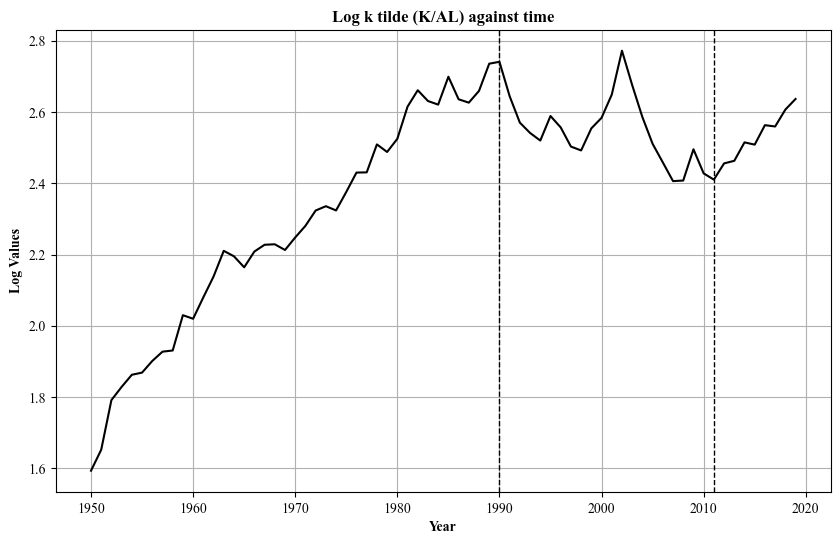

In [30]:
# Plotting K/AL (k tilde) against time

filtered_df["k tilde(K/AL)"] = filtered_df["k (K/L)"] / (np.exp(filtered_df['log A (Total Factor Productivity)']))

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Year'], np.log(filtered_df["k tilde(K/AL)"]), color='black', linestyle='-')
# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log k tilde (K/AL) against time', 
          fontfamily='Times New Roman', fontweight='bold')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)

# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)


# Show the plot
plt.show()

### Romer Model (Supplementary Data)
- Log TFP and Log Population against time

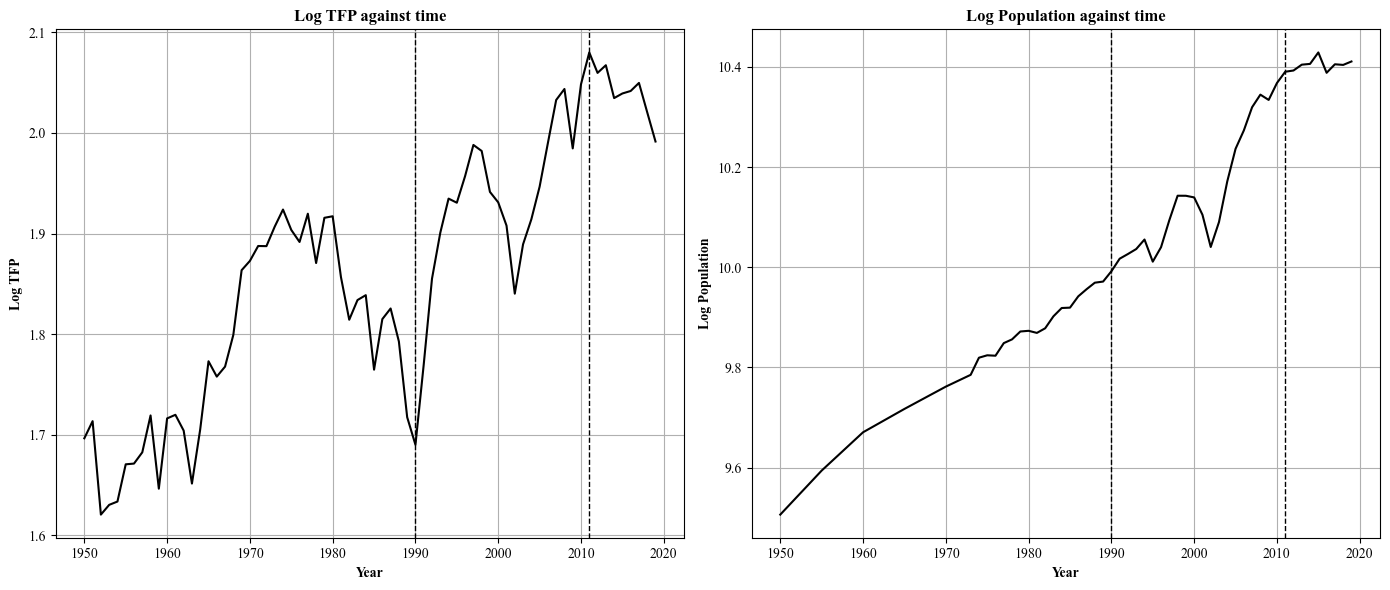

In [32]:
# Set up the figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Log TFP against time
axs[0].plot(filtered_df['Year'], filtered_df['log A (Total Factor Productivity)'], color='black', linestyle='-')
axs[0].set_xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
axs[0].set_ylabel("Log TFP", fontfamily='Times New Roman', fontweight='bold')
axs[0].set_title('Log TFP against time', fontfamily='Times New Roman', fontweight='bold')
axs[0].grid(True)
# Add vertical lines at 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    axs[0].axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)
axs[0].tick_params(axis='x', labelsize=10)
axs[0].tick_params(axis='y', labelsize=10)

# Plot Log Population against time
axs[1].plot(filtered_df['Year'], np.log(filtered_df[l]*filtered_df[avh]), color='black', linestyle='-')
axs[1].set_xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
axs[1].set_ylabel("Log Population", fontfamily='Times New Roman', fontweight='bold')
axs[1].set_title('Log Population against time', fontfamily='Times New Roman', fontweight='bold')
axs[1].grid(True)
# Add vertical lines at 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    axs[1].axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)
axs[1].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='y', labelsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### GDP vs GDP per Capita (Supplementary Data)

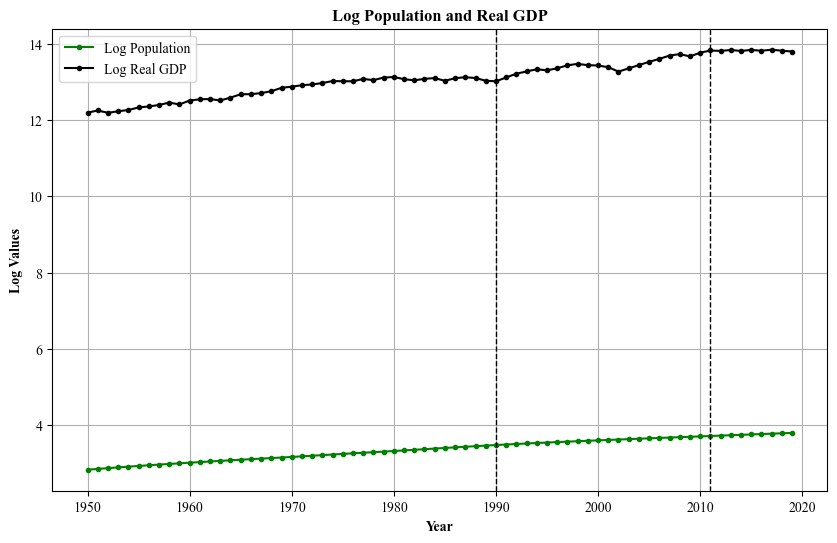

In [33]:
plt.figure(figsize=(10, 6))

# Plot Population Growth Rate
plt.plot(filtered_df['Year'], np.log(filtered_df["Population (in millions)"]), 
         color='green', linestyle='-', marker='.', label='Log Population')

# Plot Real GDP Growth Rate
plt.plot(filtered_df['Year'], np.log(filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"]), 
         color='black', linestyle='-', marker='.', label='Log Real GDP')

# Add vertical black dotted lines at year 1990 and 2011
for year in ['1990-01-01', '2011-01-01']:
    plt.axvline(x=pd.to_datetime(year), color='black', linestyle='--', linewidth=1)

# Add labels and title
plt.xlabel('Year', fontfamily='Times New Roman', fontweight='bold')
plt.ylabel("Log Values", fontfamily='Times New Roman', fontweight='bold')
plt.title('Log Population and Real GDP', 
          fontfamily='Times New Roman', fontweight='bold')

# Set tick labels to Times New Roman
plt.xticks(fontfamily='Times New Roman', fontsize=10)
plt.yticks(fontfamily='Times New Roman', fontsize=10)
plt.grid(True)

# Add legend
plt.legend(fontsize=10, loc='upper left')

# Show the plot
plt.show()


In [34]:
# Creating a dataframe called Romer
romer = pd.DataFrame({
    "Year": filtered_df["Year"],
    "Log Population": np.log(filtered_df["Population (in millions)"]),
    "Log Real GDP": np.log(filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"])
})
romer['Year'] = pd.to_datetime(romer['Year'], format='%Y')
# Calculate the growth rate for each period

# Define the growth rates
population_growth = {}
gdp_growth = {}

for start, end in timeframes:
    start_date = pd.to_datetime(str(start), format='%Y')
    end_date = pd.to_datetime(str(end), format='%Y')
    
    # Subset data within the timeframe
    subset = romer[romer["Year"].between(start_date, end_date)]
    
    if not subset.empty:
        # Log Population growth
        first_pop_value = subset["Log Population"].iloc[0]
        last_pop_value = subset["Log Population"].iloc[-1]
        population_growth[(start, end)] = last_pop_value - first_pop_value
        
        # Log Real GDP growth
        first_gdp_value = subset["Log Real GDP"].iloc[0]
        last_gdp_value = subset["Log Real GDP"].iloc[-1]
        gdp_growth[(start, end)] = last_gdp_value - first_gdp_value

# Convert results into DataFrames for both population and GDP growth
growth_df = pd.DataFrame.from_dict(population_growth, orient="index", columns=["Population Growth Rate"])
growth_df["Real GDP Growth Rate"] = pd.DataFrame.from_dict(gdp_growth, orient="index", columns=["Real GDP Growth Rate"])

growth_df.index.names = ["Timeframe"]
growth_df

,Population Growth Rate,Real GDP Growth Rate
Timeframe,,
"(1950, 1990)",0.6463,0.8219
"(1991, 2011)",0.2225,0.7064
"(2012, 2019)",0.0700,-0.0164


### Robustness check for GDP trendlines
- Real GDP
- Real GDP per capita

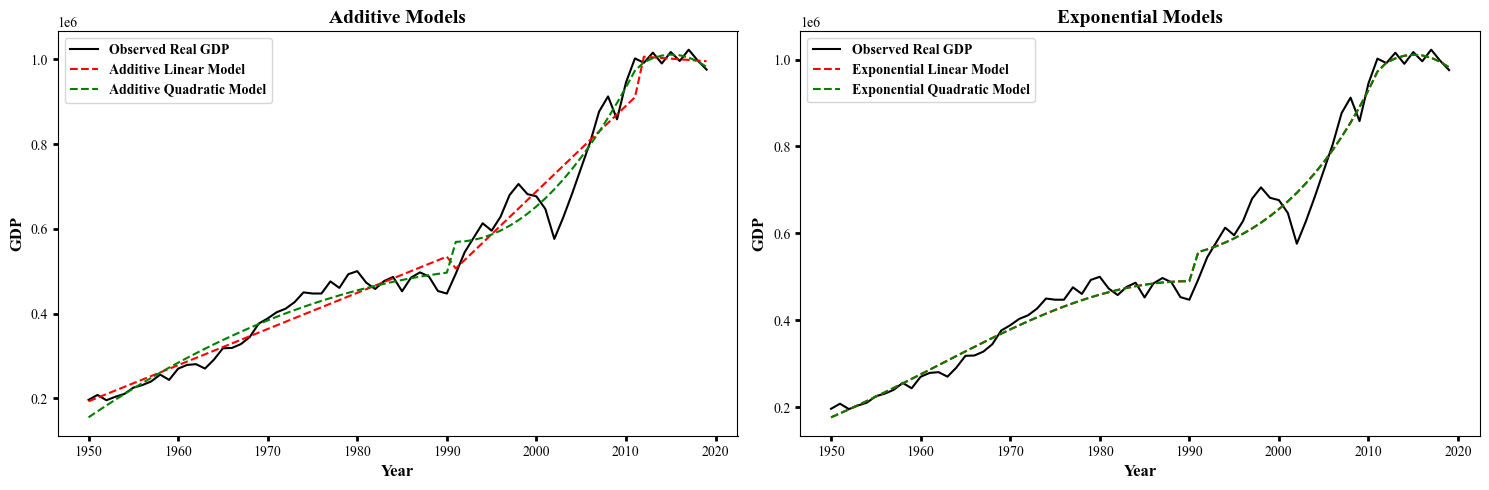

In [35]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Common style settings
font_settings = {'fontfamily': 'Times New Roman', 'fontweight': 'bold'}

# Plot Additive Models (left subplot)
ax1.plot(filtered_df["Year"], filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"], 
         label="Observed Real GDP", color="black")  
ax1.plot(filtered_df["Year"], Yhat_add_linear_, 
         label="Additive Linear Model", linestyle="--", color="red")  
ax1.plot(filtered_df["Year"], Yhat_add_quad_, 
         label="Additive Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax1.set_xlabel("Year", **font_settings, fontsize=12)
ax1.set_ylabel("GDP", **font_settings, fontsize=12)
ax1.set_title("Additive Models", **font_settings, fontsize=14)
# Formatting the ticks
ax1.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add legend
ax1.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Plot Exponential Models (right subplot)
ax2.plot(filtered_df["Year"], filtered_df["Real GDP at constant 2017 national prices (in mil. 2017US$)"], 
         label="Observed Real GDP", color="black")  
ax2.plot(filtered_df["Year"], Yhat_exp_linear_, 
         label="Exponential Linear Model", linestyle="--", color="red") 
ax2.plot(filtered_df["Year"], Yhat_exp_quad_, 
         label="Exponential Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax2.set_xlabel("Year", **font_settings, fontsize=12)
ax2.set_ylabel("GDP", **font_settings, fontsize=12)
ax2.set_title("Exponential Models", **font_settings, fontsize=14)
# Add legend
ax2.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Formatting the ticks
ax2.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Adjust layout
plt.tight_layout()
plt.show()


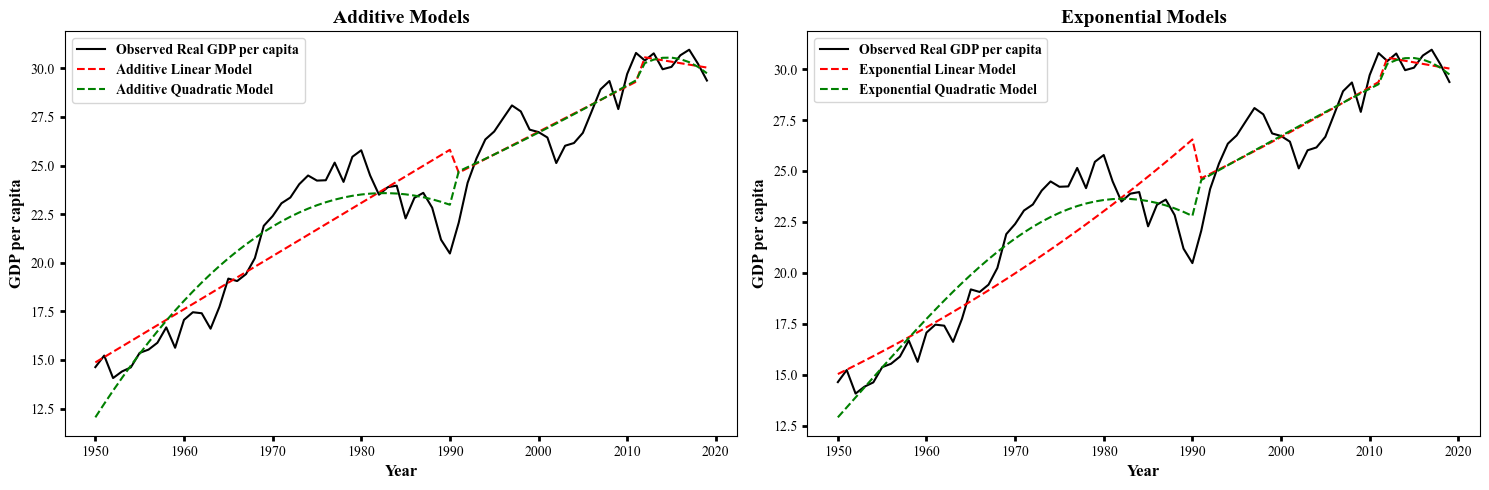

In [36]:
# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Common style settings
font_settings = {'fontfamily': 'Times New Roman', 'fontweight': 'bold'}

# Plot Additive Models (left subplot)
ax1.plot(filtered_df["Year"], filtered_df['gdp_per_capita_column'], 
         label="Observed Real GDP per capita", color="black")  
ax1.plot(filtered_df["Year"], Yhat_add_linear_percapita, 
         label="Additive Linear Model", linestyle="--", color="red")  
ax1.plot(filtered_df["Year"], Yhat_add_quad_percapita, 
         label="Additive Quadratic Model", linestyle="--", color="green")  

# Add labels and title with Times New Roman
ax1.set_xlabel("Year", **font_settings, fontsize=12)
ax1.set_ylabel("GDP per capita", **font_settings, fontsize=12)
ax1.set_title("Additive Models", **font_settings, fontsize=14)
# Formatting the ticks
ax1.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Add legend
ax1.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Plot Exponential Models (right subplot)
ax2.plot(filtered_df["Year"], filtered_df['gdp_per_capita_column'], 
         label="Observed Real GDP per capita", color="black")
ax2.plot(filtered_df["Year"], Yhat_exp_linear_percapita, 
         label="Exponential Linear Model", linestyle="--", color="red")
ax2.plot(filtered_df["Year"], Yhat_exp_quad_percapita, 
         label="Exponential Quadratic Model", linestyle="--", color="green")

# Add labels and title with Times New Roman
ax2.set_xlabel("Year", **font_settings, fontsize=12)
ax2.set_ylabel("GDP per capita", **font_settings, fontsize=12)
ax2.set_title("Exponential Models", **font_settings, fontsize=14)
# Add legend
ax2.legend(prop={'family': 'Times New Roman', 'weight': 'bold'})

# Formatting the ticks
ax2.tick_params(axis='both', which='major', labelsize=10, labelcolor='black', width=2)

# Set Times New Roman font for tick labels
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_fontproperties('Times New Roman')

# Adjust layout
plt.tight_layout()
plt.show()


### Convert filtered data to CSV and Excel

In [37]:
# Define file paths
csv_filename = "Coursework_Tan_data.csv"
excel_filename = "Coursework_Tan_data.xlsx"

# Save as CSV
filtered_df.to_csv(csv_filename, index=False)

# Save as Excel
filtered_df.to_excel(excel_filename, index=False, engine='openpyxl')